In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import *
import struct
import array
import os
from scipy.interpolate import griddata

# Athena++ modules
# import athena_read
import athena_read_select
import athena_read as athr
import h5py
import netCDF4
import xarray as xr
import scipy as sp

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
filename = 'disk.out1.00100.athdf'

In [3]:
q = 0.9e-3
Rh = (q/3) ** (1/3)

In [4]:
Rh

0.06694329500821695

In [5]:
# Step 1: build cylindrical coordinates around the planet
planet_pos = np.array([1.0, np.pi/2, np.pi])
R_Hill = (0.9e-3 / 3) ** (1/3)
_p_phi, _p_z, _p_r = np.linspace(0, 2*np.pi, 128), np.linspace(0, 1.25*R_Hill, 128), np.linspace(0, 1.25*R_Hill, 128)

p_phi, p_z, p_r = np.meshgrid(_p_phi, _p_z, _p_r, indexing='ij')

g_r = np.sqrt((planet_pos[0] + p_r * np.cos(p_phi))**2 + (p_r * np.sin(p_phi))**2)
g_phi = np.arctan2(p_r * np.sin(p_phi), planet_pos[0] + p_r * np.cos(p_phi)) + planet_pos[2]
g_theta = np.arctan2(p_z, g_r) + planet_pos[1]

xi = np.vstack([g_phi.flatten(), g_theta.flatten(), g_r.flatten()]).T # the list of points we will use to interpolate data

# Step 2: read the data
ds_raw = athr.athdf(filename, raw=True, quantities=['rho', ], )

block_size = ds_raw['MeshBlockSize']
root_grid_size = ds_raw['RootGridSize']
levels = ds_raw['Levels'][:]
logical_locations = ds_raw['LogicalLocations'][:]

lev = 4  # find the boundaries of level 4 and read in the data using the bounding box
idx_to_merge = np.argwhere(levels==lev).ravel()

bounding_box = np.array([[g_r.min()-np.diff(_p_r).mean(), g_r.max()+np.diff(_p_r).mean()], 
                         [g_theta.min()-np.diff(_p_z).mean(), g_theta.max()+np.diff(_p_z).mean()], 
                         [g_phi.min()-np.diff(_p_phi).mean(), g_phi.max()+np.diff(_p_phi).mean()], 
                        ])
ds = athr.athdf(filename, level=lev, fast_restrict=True, quantities=['rho', 'vel1', 'vel2', 'vel3'],
                x1_min=bounding_box[0][0], x1_max=bounding_box[0][1], x2_min=bounding_box[1][0], x2_max=bounding_box[1][1], x3_min=bounding_box[2][0], x3_max=bounding_box[2][1], )

# Step 3: do data interpolation
interp_rho_generator = sp.interpolate.RegularGridInterpolator((ds['x3v'], ds['x2v'], ds['x1v']), ds['rho']) # assuming it is Cartesian enough
interp_rho = interp_rho_generator(xi).reshape([128, 128, 128])

interp_vel1_generator = sp.interpolate.RegularGridInterpolator((ds['x3v'], ds['x2v'], ds['x1v']), ds['vel1']) # assuming it is Cartesian enough
interp_vel1 = interp_vel1_generator(xi).reshape([128, 128, 128])

interp_vel2_generator = sp.interpolate.RegularGridInterpolator((ds['x3v'], ds['x2v'], ds['x1v']), ds['vel2']) # assuming it is Cartesian enough
interp_vel2 = interp_vel1_generator(xi).reshape([128, 128, 128])

interp_vel3_generator = sp.interpolate.RegularGridInterpolator((ds['x3v'], ds['x2v'], ds['x1v']), ds['vel3']) # assuming it is Cartesian enough
interp_vel3 = interp_vel1_generator(xi).reshape([128, 128, 128])

# Step 4: re-project global velocities onto the coordinates around the planet (u_rp and u_zp = radial and vertical velocities)
interp_u_rp = (interp_vel1 * np.sin(g_theta) + interp_vel2 * np.cos(g_theta)) * np.cos(p_phi - (g_phi - planet_pos[2])) + interp_vel3 * np.sin(p_phi - (g_phi - planet_pos[2]))
interp_u_zp = interp_vel1 * np.cos(g_theta) + interp_vel2 * np.sin(g_theta)

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_24367/1981626970.py:16: RuntimeWarning: invalid value encountered in log10
  im = ax.pcolormesh(_p_r/R_Hill, _p_z/R_Hill, np.log10(interp_u_rp.mean(axis=0)), shading='nearest', cmap='Reds', vmin=-3.5, vmax=-0.9)
/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_24367/1981626970.py:17: RuntimeWarning: invalid value encountered in log10
  im = ax.pcolormesh(_p_r/R_Hill, _p_z/R_Hill, np.log10(-interp_u_rp.mean(axis=0)), shading='nearest', cmap='Blues', vmin=-3.5, vmax=-0.9)


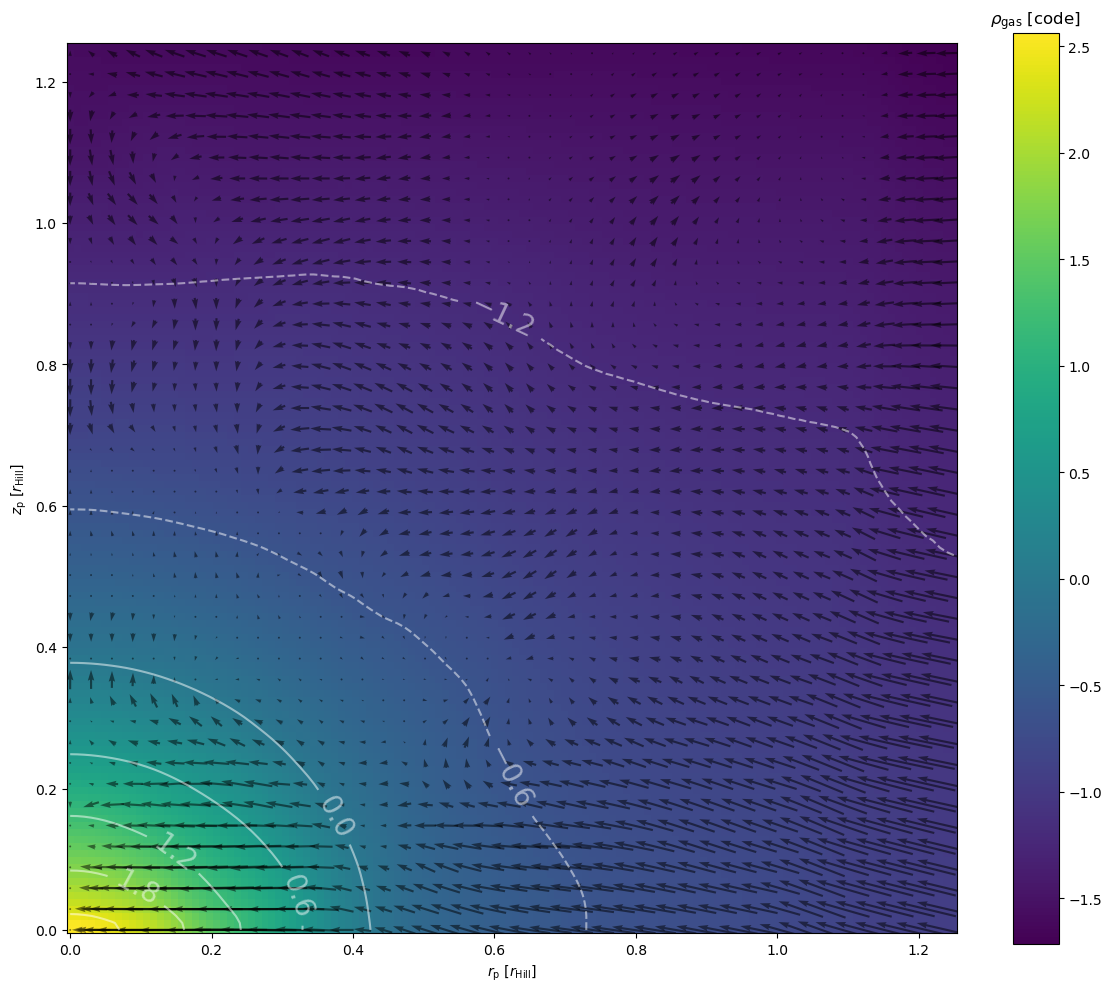

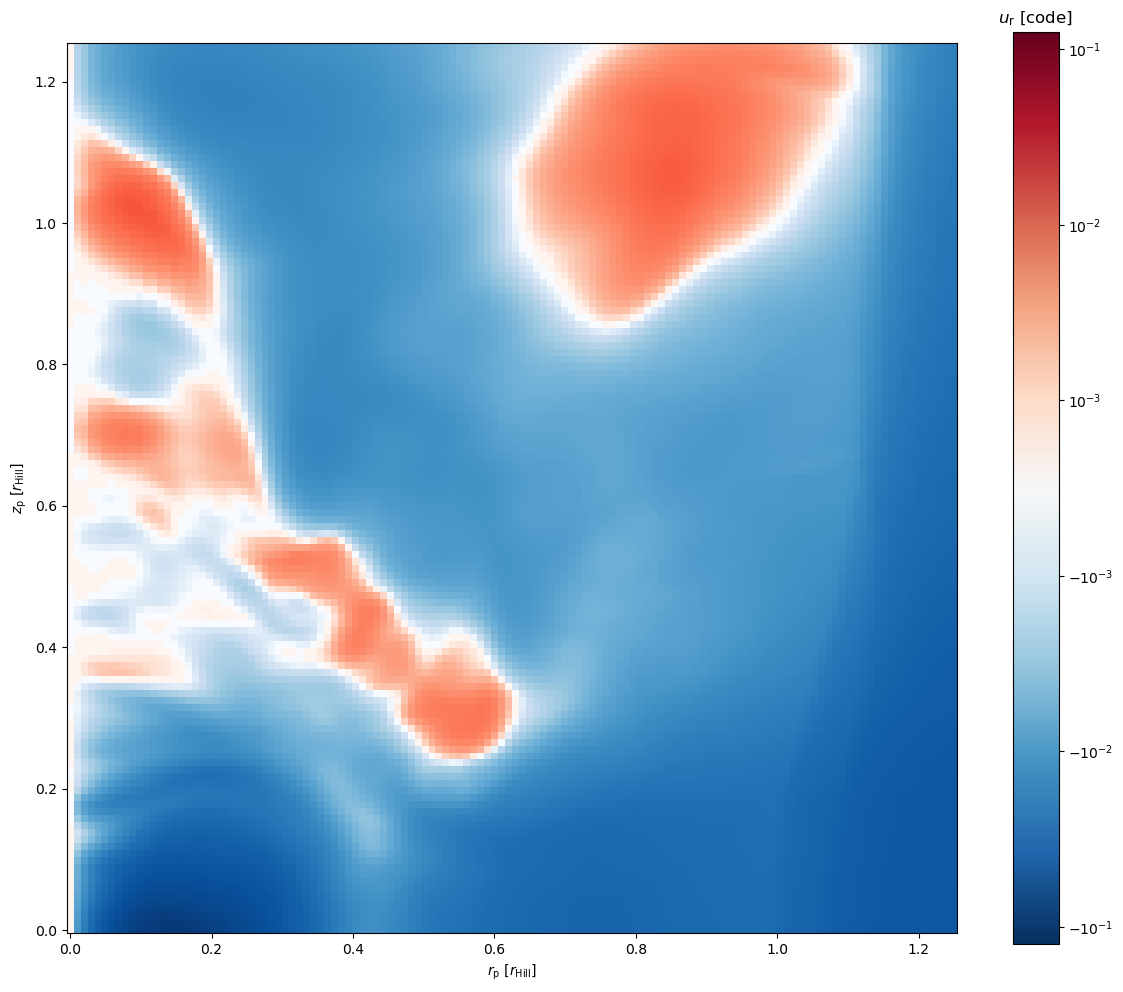

In [6]:
# For first picture:
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.pcolormesh(_p_r/R_Hill, _p_z/R_Hill, np.log10(interp_rho.mean(axis=0)), shading='nearest')
cax = fig.colorbar(im)
cax.ax.set_title(r"$\rho_{\rm gas}$ [code]")

CS = ax.contour(_p_r/R_Hill, _p_z/R_Hill, np.log10(interp_rho.mean(axis=0)), 7, colors='w', alpha=0.5)
ax.clabel(CS, fontsize=20, inline=True)
ax.quiver(_p_r[::3]/R_Hill, _p_z[::3]/R_Hill, interp_u_rp.mean(axis=0)[::3,::3], interp_u_zp.mean(axis=0)[::3,::3], color=(0, 0, 0, 0.5), scale=0.75, pivot='mid')

ax.set(xlabel=r"$r_{\rm p}$ [$r_{\rm Hill}$]", ylabel=r"$z_{\rm p}$ [$r_{\rm Hill}$]", aspect=1.0)
fig.tight_layout()

# For second picture:
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.pcolormesh(_p_r/R_Hill, _p_z/R_Hill, np.log10(interp_u_rp.mean(axis=0)), shading='nearest', cmap='Reds', vmin=-3.5, vmax=-0.9)
im = ax.pcolormesh(_p_r/R_Hill, _p_z/R_Hill, np.log10(-interp_u_rp.mean(axis=0)), shading='nearest', cmap='Blues', vmin=-3.5, vmax=-0.9)

im = ax.pcolormesh([[]], cmap='RdBu_r', vmin=-2.6, vmax=2.6, rasterized=True)
cax = fig.colorbar(im); cax.set_ticks([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]); cax.ax.set_title(r"$u_{\rm r}$ [code]")
cax.set_ticklabels([r'$-10^{'+str(x)+'}$' for x in [-1, -2, -3]] + [r'$10^{'+str(x)+'}$' for x in [-3, -2, -1]])  

ax.set(xlabel=r"$r_{\rm p}$ [$r_{\rm Hill}$]", ylabel=r"$z_{\rm p}$ [$r_{\rm Hill}$]", aspect=1.0)
fig.tight_layout()
